# Practica 1 Optimización para Grandes Volumenes de Datos - Cross Validation
## Implementación paralelizada y evaluación de un algoritmo de ML supervisado

Esta entrega ha sido realizada por Adrián Contreras Castillo y Jaime González Delgado.

## Introducción

Para la realización de esta práctica se parte de la versión centralizada proporcionada por la asignatura. La versión centralizada dispone el entrenamiento de un algoritmo de ML sin paralelizar donde tampoco se incluye la regularización en la funció de coste ni tampoco en las derivadas necesarias para el cálculo del descenso de gradiente. Además la versión proporcionada tampoco hace uso de la vectorización de las operciones que ofrece la librería Numpy. El empleo de numpy arrays en vez de las listas de python suponen la introducción de operadores de vectores y matrices, así como, un aumento en la velocidad de ejecución. Lo que se busca con el desarrollo de esta práctica es implementar las fucionalidades anteriormente descritas de tal forma que se otenga un código que haga empleo de la paralelización que ofrece PySpark, con el fin de reducir los tiempos de ejecución, evaluando también la configuración de workers más optima.

El siguiente código cuenta con la implementación de la paralelización, además en aquellas funciones donde se puede hacer uso de los operadores de numpy han sido modificas con el fin de optimizar la velocidad de computo. También, la implementación de la función de coste, asi como el cálculo de las derivadas incluye la regularización.

In [ ]:
import findspark

findspark.init()

from pyspark import SparkContext
import numpy as np
import time
import random
import math
from operator import add

In [ ]:
sc = SparkContext("local[*]", "practica")

24/02/19 10:32:14 WARN Utils: Your hostname, vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/02/19 10:32:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/02/19 10:32:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Proceso de paralelización

In [ ]:
def readFile (filename):
    """Arguments:
    filename – name of the spam dataset file
    12 columns: 11 features/dimensions (X) + 1 column with labels (Y)
    Y -- Train labels (0 if normal traffic, 1 if botnet)
    m rows: number of examples (m)
    Returns:
    An RDD containing the data of filename. Each example (row) of the file
    corresponds to one RDD record. Each record of the RDD is a tuple (X,y).
    “X” is an array containing the 11 features (float number) of an example
    “y” is the 12th column of an example (integer 0/1)"""
    rdd = sc.textFile(filename)
    column_data = rdd.map(lambda x: (np.array([float(elem) for elem in x.split(",")[:-1]]),
                                     int(x.split(",")[-1])))
    return column_data

In [ ]:
def normalize (RDD_Xy):
    """Arguments:
    RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple
    (X,y).
    “X” is an array containing the 11 features (float number) of an example
    “y” is the label of the example (integer 0/1)
    Returns:
        An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1)"""
    num_rows = RDD_Xy.count()

    RDD_X = RDD_Xy.map(lambda x: x[0])

    sum_values = RDD_X.reduce(lambda x,y: x+y)
    mean_values = sum_values/num_rows

    square_diff = RDD_X.map(lambda x: (x-mean_values)**2).reduce(lambda x, y: x+y)
    std_values = np.sqrt(square_diff/num_rows)

    RDD_Xy_norm = RDD_Xy.map(lambda x: (((x[0]-mean_values)/std_values), x[1]))

    return RDD_Xy_norm


In [ ]:
def get_y_hat (x,w):
    #print (x.shape, w.shape)
    return sigmoid(get_dot_xw(x,w))

def get_dot_xw(x,w):
    x = np.append(x,1)
    res = np.dot(x,w)
    return res

def sigmoid(x):
    try:
        return 1. / (1.+math.exp(-x))
    except OverflowError:
        return 0.0

In [ ]:
def fcost(y, y_hat):
    #print ("cost:",y,y_hat)
    # compute loss/cost for one element "y_hat" and one label "y"
    epsilon=0.00000001
    if y == 1:
        return -np.log(y_hat if y_hat > 0. else epsilon)
    else:
        return -np.log(1-y_hat if 1-y_hat >0. else epsilon)

In [ ]:
# Update model weights using current weights, their derivatives and the learning rate
def update_ws(w,dw,lr):
    w_ = np.array(w, dtype=float)
    dw_ = np.array(dw, dtype=float)
    #print ("shapes w y dw",w.shape,dw.shape)
    tmp = w_ - lr*dw_
    neww = tmp
    return neww

# Get derivatives of Cost function for each element of the dataset
def get_derivatives(x_y, w, y_hat):
    x = np.array(x_y[0], dtype=float)
    y= x_y[1]
    diff_y = y_hat - y
    # Vectorized version
    res = x*diff_y
    res = np.append(res, diff_y)
    return res

In [ ]:
def train (RDD_Xy, iterations, learning_rate, lambda_reg, print_trace=False):
    """Arguments:
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple
    (X,y).
    “X” is an array containing the 11 features (float number) of an example
    “y” is the label of the example (integer 0/1)
    iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent
    lambda_reg – regularization rate
    Returns:
    A list or array containing the weights “w” and bias “b” at the end of the
    training process"""
    num_rows = RDD_Xy.count()

    w = []
    for i in range(12):
        w.append(random.uniform(0.0, 1.0)) #list of weights also include the bias

    iterac = 0
    costs = []
    j_avg = 0

    while(iterac < iterations):
        w = np.array(w)

        y_hat = RDD_Xy.map(lambda x: (x[0],x[1],get_y_hat(x[0], w)))

        j_sum = y_hat.map(lambda x: fcost(x[1],x[2])).reduce(lambda x,y:x+y)

        # compute total cost as the average of all costs "j" , assign to j_avg
        j_avg= j_sum/float(num_rows)+(lambda_reg/(2*len(w-1)))*np.sum(np.power(w[:-1],2))

        # print Cost "j" and iteration
        if print_trace:
            print ("iteration",iterac," Cost:",j_avg)

        dw_tot = y_hat.map(lambda x: get_derivatives((x[0],x[1]), w,x[2])).reduce(lambda x,y:x+y)

        w_aux = w.copy()
        w_aux[-1] = 0
        dw_tot = dw_tot/num_rows +lambda_reg*(len(w)-1)*w_aux

        w=update_ws(w, dw_tot,learning_rate)

        iterac += 1

    return w




In [ ]:
def predict (w, X):
    """Arguments:
    w -- weights and bias
    X – Example to be predicted
    Returns:
    Y_pred – a value (0/1) corresponding to the prediction of X"""
    threshold=0.5
    y_hat=get_y_hat(X,w)
    return 1 if y_hat > threshold else 0


In [ ]:
def accuracy (w, RDD_Xy):
    """Arguments:
    w -- weights and bias
    RDD_Xy – RDD containing examples to be predicted
    Returns:
    accuracy -- the number of predictions that are correct divided by the number
    of records (examples) in RDD_xy.
    Predict function can be used for predicting a single example"""
    num_rows = RDD_Xy.count()

    pred = RDD_Xy.map(lambda x: (predict(w,x[0]),x[1]))

    num_correct = pred.map(lambda x: 1 if x[0]==x[1] else 0).reduce(lambda x,y: x+y)

    return num_correct*100.0/float(num_rows)



# Proceso de Cross-validation

In [ ]:
def transform(data, num_blocks_cv=10):
    data_cv = data.map(lambda x: (x, random.randint(0,num_blocks_cv-1)))
    return data_cv

In [ ]:
def get_block_data(data, block):
    tr_data = data.flatMap(lambda x: [x[0]] if x[1]!=block else [])
    test_data = data.flatMap(lambda x: [x[0]] if x[1]==block else [])
    return tr_data, test_data

In [ ]:

nIter = 10
learningRate = 1.5
path = "./botnet_reduced_l.csv"

data = readFile(path)

data = normalize(data)

num_blocks_cv=10

data_cv = transform(data)

avg_acc = []

for i in range(num_blocks_cv):
    tr_data, test_data = get_block_data(data_cv,i)
    ws = train(tr_data, nIter, learningRate, lambda_reg=0.0)
    acc = accuracy(ws, test_data)
    avg_acc.append(acc)
    print("acc: ", acc)

print(np.mean(avg_acc))

sc.stop()

acc:  93.20927440534254


acc:  93.25538892922414


acc:  91.76664255605716


acc:  92.87943474895764


acc:  92.34147680483119


acc:  94.81657282803545


acc:  92.62984911110004


acc:  92.7761371814279


acc:  93.43632253202713


acc:  93.35615411523662
93.04672532122399


In [ ]:
worker_times_cv = dict()
for i in [1,2,3,4,5,6]:
    lst_times_cv = []
    for j in range(3):
        sc = SparkContext(f"local[{i}]", f"practica_{i}_{j}")

        data = readFile(path)

        data = normalize (data)

        num_blocks_cv=10

        data_cv = transform(data)

        avg_acc = []

        t1=time.time()
        for k in range(num_blocks_cv):
            tr_data, test_data = get_block_data(data_cv,k)
            ws = train(tr_data, nIter, learningRate, lambda_reg=0.0)
            acc = accuracy(ws, test_data)
            avg_acc.append(acc)
        t2=time.time()
        lst_times_cv.append(t2-t1)
        print(np.mean(avg_acc))
        sc.stop()
    print(f"CV time for {nIter} iterations and {i} workers: {np.mean(lst_times_cv)}")
    worker_times_cv[i] = np.mean(lst_times_cv)

93.33590862914613


92.8151683788553


92.63243482058512
CV time for 10 iterations and 1 workers: 1846.4534258842468


93.16158164211683


92.79334198915441


92.7379236668094
CV time for 10 iterations and 2 workers: 1382.1440393924713


92.8862227400617


93.0874783164825


92.83939289746854
CV time for 10 iterations and 3 workers: 1071.7555266221364


93.16478888389565


92.78791015002865


93.1491244415889
CV time for 10 iterations and 4 workers: 653.3563641707102


92.70552057720718


92.83658959190878


92.45004416087772
CV time for 10 iterations and 5 workers: 500.76796023050946


93.04533387519646


92.86373276763956


92.81054188958687
CV time for 10 iterations and 6 workers: 503.579980134964


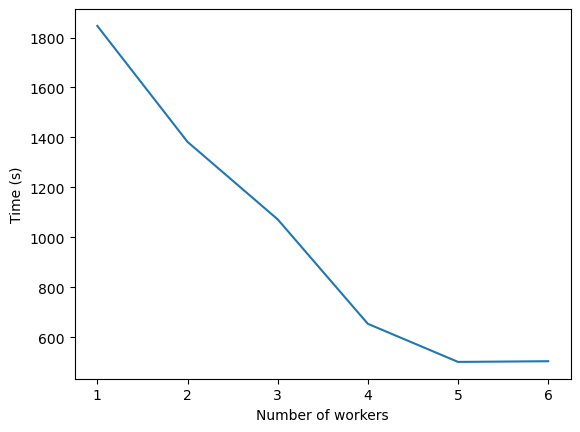

In [ ]:
import matplotlib.pyplot as plt
plt.plot(worker_times_cv.keys(), worker_times_cv.values())
plt.xlabel('Number of workers')
plt.ylabel('Time (s)')
plt.show()

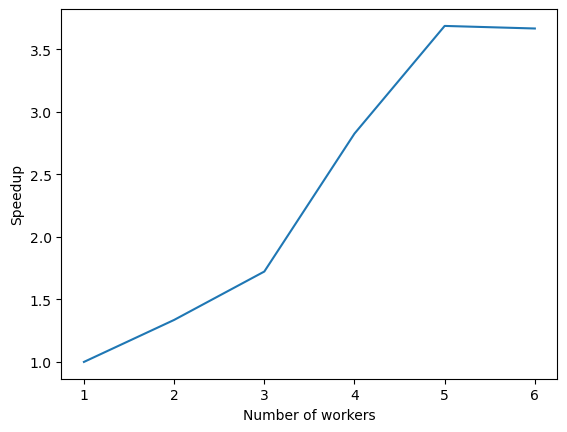

In [ ]:
speedup = [worker_times_cv[1]/t for t in worker_times_cv.values()]
plt.plot(worker_times_cv.keys(), speedup)
plt.xlabel('Number of workers')
plt.ylabel('Speedup')
plt.show()

### Análisis de rendimiento del proceso de paralelización del Cross-Validation

Al igual que en el anterior experimento, las condiciones de ejecución son las mismas para cada número de workers, con un máximo de 4 núcleos de CPU disponibles en la máquina virtual. También, se ha repetido 3 veces la ejecución para cada configuración de workers obteniendose la media de las mismas. Desarrollando las mismas graficas de tiempo de coste, en segundos, y de speed-up.

Como cabía preveer, a partir de los conclusiones obtenidas en la anterior apartado, a medida que se aumenta el número de nodos para paralelizar mejores rendimientos en tiempo de computo se obtiene. En este proceso el pico mínimo se alcanza usando una configuración con 5 workers, lo que supone una reducción en más de la mitad de tiempo con respecto al empleo de un solo nodo. A diferencia de lo observado anteriormente, si que existe una considerable ventaja en emplear más nodos que núcleos habilitados, viendose reducido los tiempos de computo cuando usas 5 o 6 workers respecto al empleo de 4. A pesar de ello, se sigue alcanzando una asintota entre el empleo de 5 y 6 nodos. En terminos de speedup, tampoco se describe un proceso de crecimiento lineal, alcanzando un pico máximo de ejecución que es más de 3.5 veces más rápido que la ejecución de un solo worker. Estabilizándose la curva al superar la configuración de 5 workers.

Como conclusión se vuelve a observar que la paralelización de procesos supone una gran ventaja en la reducción de tiempos, así como la optimización del rendimiento del sistema. Además, este estudio permite proporcionar información de interés para identificar ka configuración de workers óptimos que máximice el rendimiento en función de los recursos disponibles.